# Tutorial:   Statistics and Biomechanics  (ISB 2019, Calgary)

&copy; Todd Pataky, 2019

# Notebook 2:  Probability functions

This notebook requires Matlab's [Statistics Toolbox](https://www.mathworks.com/products/statistics.html).

The purposes of this notebook are:
1. To describe the probability functions that are relevant to classical hypothesis testing
2. To highlight how probability functions are used in classical hypothesis testing to calculate (a) critical thresholds, and (b) p values.
3. To clarify the meaning of "parameteric" probability functions

___
### Part 1: Visualizing probability functions

The four most important probability functions are:

* [Probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF)
* [Cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF)
* [Survival function](https://en.wikipedia.org/wiki/Survival_function) (SF)
* [Inverse survival function](https://en.wikipedia.org/wiki/Survival_function) (ISF)

A PDF characterizes the distribution of the randomly variable. The random variable represents random fluctuations in either the underlying, observed data, or in a test statistic like the t value.

The PDF for the Gaussian distribution is:

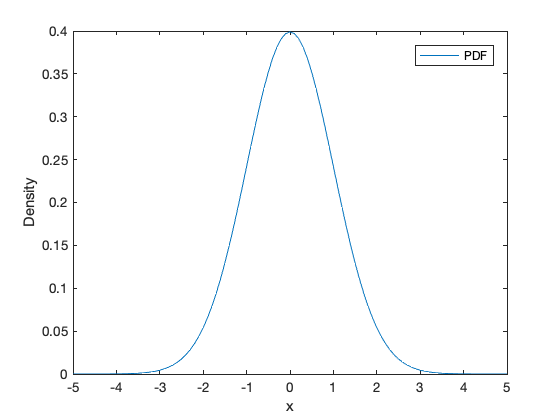

In [1]:
x     = linspace(-5, 5, 101);

mu    = 0;
sigma = 1;
f     = pdf('Normal', x, mu, sigma);

plot(x, f)
xlabel('x')
ylabel('Density')
legend('PDF')

Here $x$ is the random variable and "density" represents the probability that $x$ will adopt a value in the range [$x_0$, $x_1$], where $x_0$ and $x_1$ are arbitrary values ($-\infty < x_0 < x_1 < +\infty$). Note that "density", unlike the other three probability functions discsussed in this notebook, has no practical interpretation for a single value of $x$; a PDF only acquires practical meaning for a range of values [$x_0$, $x_1$].

In the PDF plot above we can see that, by symmetry, the probability that $x$ is greater than zero (i.e., in the range [0, $\infty$]) is 0.5. This can be verified, and more generally, probabilities can be calculated in two ways:

1. Analytically:  using mathematical functions
2. Numerically: simulating random data to verify the analytical results

Analytical calculations are very fast (a few ms) , and numerical simulations are comparatively very slow (thousands of times slower). The analytical approach is to use the survival function (SF) or cumulative distribution function (CDF), which are simply PDF integrals:

$$\textrm{SF}(u) = \int_{u}^{+\infty} \textrm{PDF}(x)dx$$

$$\textrm{CDF}(u) = \int_{-\infty}^{u} \textrm{PDF}(x)dx$$

In [2]:
%in Matlab, use: SF = 1 - CDF;
p = 1 - cdf('Normal', 0, mu, sigma);
fprintf('P(x>0) = %.5f', p);

P(x>0) = 0.50000

Note that "survival" can be interpreted as the probability that a random variable will survive a threshold $u$, or $P(x>u)$. The CDF provides the complimentary probability: $P(x<u)$:

In [3]:
p = cdf('Normal', 0, mu, sigma);
fprintf('P(x<0) = %.5f', p);

P(x<0) = 0.50000

The complimentary nature of the SF and CDF can be seen by choosing a different threshold value $u$:

In [4]:
%This complimentary nature is obvious in matlab, when using (sf = 1 - cdf),
%  but it is not obvious in other packages which separately implement the SD
%  To match the Python notebook, the analyses is replicated here.

u     = 1.0;
p_sf  = 1 - cdf('Normal', u, mu, sigma);
p_cdf = 1 - cdf('Normal', u, mu, sigma);

fprintf('P(x>0) = %.5f\n', p_sf)
fprintf('P(x<0) = %.5f\n', p_cdf)
fprintf('P(x<0) + P(x>0) = %.5f\n', p_cdf + p_sf )

P(x>0) = 0.15866
P(x<0) = 0.15866
P(x<0) + P(x>0) = 0.31731


The complimentary nature of the CDF and SF can also be seen when plotting the whole functions:

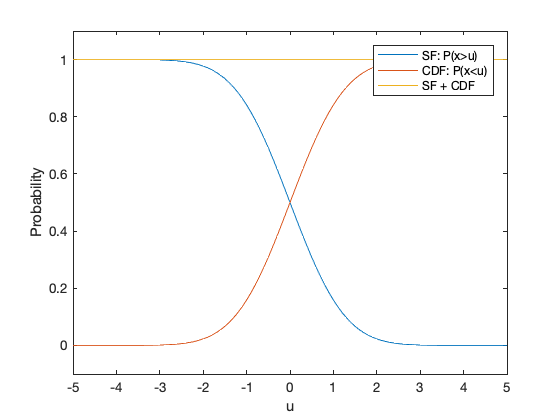

In [5]:
u     = linspace(-5, 5, 101);
p_sf  = 1 - cdf('Normal', u, mu, sigma);
p_cdf = cdf('Normal', u, mu, sigma);

plot(u, p_sf)
hold on
plot(u, p_cdf)
plot(u, p_sf + p_cdf)
xlabel('u')
ylabel('Probability')
ylim([-0.1 1.1])
legend('SF: P(x>u)', 'CDF: P(x<u)', 'SF + CDF')

Note that the sum of the SF and CDF for a threshold $u$ is always one. That is, the CDF represents the interval [$-\infty$, $u$], and the SF represents the interval [$u$, $\infty$], so together they represent the interval [$-\infty$, $+\infty$], and the probability that $x$ lies in this interval is 1, or 100%.

While the CDF is usually taught in introductory Statistics class, the SF is more directly relevant to hypothesis testing, as we shall see below.

The final probability function considered in these notebooks is the inverse survival function (ISF), which provides the value $u$ for a specific probability. From the SF plot above we can see that the probability that $x$ is greater than $u$=1 is approximately 0.1. The actualy probability for $u$=1 is:

In [6]:
u    = 1.0;
p    = 1 - cdf('Normal', u, mu, sigma);
fprintf('P(x>1) = %.5f', p)

P(x>1) = 0.15866

To find the actual value of $u$ for which $P(x>u)=0.1$, we can use the ISF like this: 

In [7]:
% in matlab use isf(p) = icdf(1-p) 

p    = 0.1;
u    = icdf('Normal', 1-p, mu, sigma);
fprintf('u = = %.5f', u)

u = = 1.28155

Thus $P(x>1.28155) = 0.1$.

We can view the entire ISF like this:

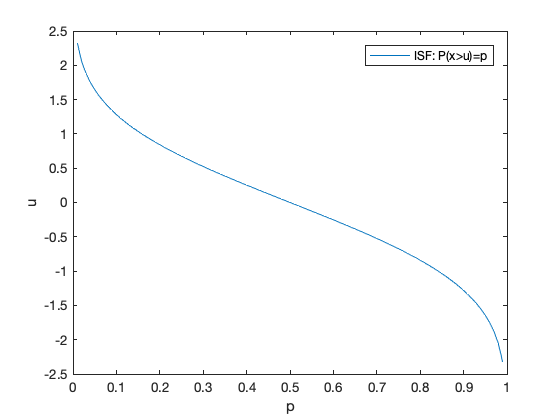

In [8]:
p    = linspace(0, 1, 101);
u    = icdf('Normal', 1-p, mu, sigma);

plot(p, u)
xlabel('p')
ylabel('u')
legend('ISF: P(x>u)=p')

As an aside, just like the SF is complimentary to the CDF, the ISF is complimentary to the [percentile point function](https://en.wikipedia.org/wiki/Quantile_function) (PPF):

In [9]:
%Matlab does not directly implement PPFs, so this analysis has been removed

That is, the ISF for probability $p$ is equivalent to the PPF for probability $(1-p$).

To avoid interpretation complications associated with these complimentary probabilities (SF and CDF, ISF and PPF), the remainder of these notebooks considers only the SF and ISF.

___

### Part 2: Classical hypothesis testing: critical thresholds and p values

Consider the following dataset set and the one-sample hypothesis testing results:

In [10]:
rng(58)      %seed=58 chosen to obtain a p value close to 0.05
J     = 8;   %sample size
mu    = 80;  %true population mean
sigma = 10;  %true population SD

y     = mu + sigma * randn(J,1);
[h,p,ci,stats] = ttest(y, mu);
fprintf('One-sample t test results:  t = %.3f, p = %.3f', stats.tstat, p)

One-sample t test results:  t = -1.999, p = 0.086

The p value is greater than $\alpha=0.05$, so the null hypothesis ($H_0: \overline{y} = \mu$) is not rejected.

The t value for the one-sample test is defined as:

$$ t = \frac{ \overline{y} - \mu }{ s } \sqrt{J} $$

where $\overline{y}$ is the sample mean, $s$ is the sample SD, and $J$ is the sample size. First let's verify the t value returned from the one-sample t test above:

In [11]:
t     = ( mean(y) - mu ) / std(y) * J^0.5;
fprintf('t value = %.3f', t)

t value = -1.999

Good, the t value is the same as the one returned by the third-party t test.  What about the p value?  To calculate the p value we need:

* The survival function for the t statistic; this is defined by the degrees of freedom $\nu$, which is $(J-1)$ for a one-sample test; see more in Part 3 of this notebook
* The threshold $u$ (in this case: the sample's $t$ value)

In [12]:
nu    = J - 1;   %degrees of freedom
p     = 1 - cdf('t', t, nu);
fprintf('p value = %.3f', p)

p value = 0.957

Oh no! The p value is different!  Why?  The built-in test uses [two-tailed inference](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests) by default. The survival function (SF) described in the section above pertains to the region [$u$, $+\infty$], but two-tailed inference pertains **simultaneously** to [$-\infty$, $-u$] and [$u$, $+\infty$]. The built-in SF only reports one-tailed p values. To change it to a two-tailed results we simply multiply by two:

In [13]:
p     = 2 * (1 - cdf('t', abs(t), nu));   %two-tailed inference
fprintf('p value = %.3f', p)

p value = 0.086

For distributions symmetrical about $u$=0, the random variable $t$ is twice as likely to lie in [$-\infty$, $-u$] or [$u$, $+\infty$] than it is to lie in just one of those regions.

Note that, had we conducted one-tailed inference, the p value would have been less than $\alpha$ null hypothesis would have been rejected.  This illustrates a very important point: **one mustn't choose the type of statistical analysis AFTER seeing the results**. Ideally the analyses should be decided well before the experiment is actually conducted. Otherwise an investigator could apply arbitrary analyses (like one- vs. two-tailed inference) to support a particular data interpretation.

More generally, we see that the SF yields hypothesis testing's p values. So in order to conduct hypothesis testing we need only the following:

* Survival function (appropriate to the test statistic and sample size)
* Threshold (the random sample's test statistic's value)

The interpretation above (using the sample's t value as the threshold $u$ to calculate the p value) can be regarded as **forward inference**, which is analogous to forward kinematics in biomechanics. The inverse approach is also possible: use a p value to calculate a threshold $u$ using the ISF:

In [14]:
u    = icdf('t', 1 - 0.5*p, nu);
fprintf('u for p=%.3f = %.3f', p, u )

u for p=0.086 = 1.999

Note that this value of $u$ is the same as the t value. When the p value is $\alpha$, the resulting threshold computed using the ISF is called the **critical threshold**, which we shall denote $t^*$:

In [15]:
alpha = 0.05;
tstar = icdf('t', 1 - 0.5*alpha, nu);   %two-tailed inference

fprintf('Critical threshold for alpha=%.3f = %.3f', alpha, tstar)

Critical threshold for alpha=0.050 = 2.365

This implies that the t value would have to be greater than $t^*$ in order to reject the null hypothesis. Since the sample t value is less than $t^*$, the null hypothesis is not rejected.

___

### Part 3: Parametric probability functions

You may have heard the terms "parametric" and "nonparametric" in the context of hypothesis testing. Notebook 8 considers nonparametric inference. The analyses above use parametric inference. What does "parametric inference" mean?

In short, **parameteric inference** means simply that mathematical functions, which are defined by a small number of parameters, are used to compute probabilities.

In the example from Part 2 above, the t distribution was used to conduct inference. This is a parametric distribution, and its functions are parameteric, defined by one parameter: $\nu$, which is effectively the same as sample size. Let's check the effects of $\nu$ on the survival function:

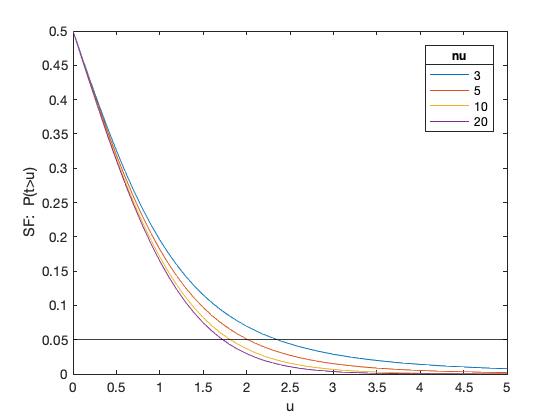

In [16]:
u     = linspace(0, 5, 51);
nu    = [3 5 10 20];
p     = zeros( numel(nu), numel(u) );
for i = 1:numel(nu)
    p(i,:) = 1 - cdf('t', u, nu(i));
end

plot(u, p')
hold on
line(get(gca,'XLim'), alpha*[1 1],'Color','k')
xlabel('u')
ylabel('SF:  P(t>u)')
hleg = legend( arrayfun(@num2str, nu, 'UniformOutput', false) );
htitle = get(hleg, 'Title');
set(htitle,'String','nu')

The horizontal line depitcts the threshold for significance. Note that $\nu$ is the (only) parameter that defines the  SF.

While the effects of $\nu$ do not seem large, consider the differences for u = 2.5:

In [17]:
p = 2 * (1 - cdf('t', 2.5, nu));

for i = 1:4
    fprintf('nu = %d, p = %.5f\n', nu(i), p(i) )
end

nu = 3, p = 0.08771
nu = 5, p = 0.05449
nu = 10, p = 0.03145
nu = 20, p = 0.02123


This implies that, simply by changing the sample size from 4 to 21, you can change probability results four-fold. In other words, probability results can be very sensitive to sample size. This is why it's important to choose an appropriate sample size: to ensure that a specific effect (i.e., a t value) will be deemed statistically significant if observed. This is the essence of [power analysis](https://en.wikipedia.org/wiki/Power_(statistics)).

Power analysis is not addressed further in these notebooks. For further reading, and for software implementing power analysis for datasets like those in Biomechanics, see the [power1d package](http://www.spm1d.org/power1d/).

___

### Summary

* "Forward inference": use the SF to calculate probability values based on the sample's test statistic
* "Inverse inference": use the ISF to calculate the critical threshold based on the desired probability value


Note that "forward inverse" and "inverse inference" are not terms from Statistics, but they are used here because they are similar to forward kinematics (FK) and inverse kinematics (IK):
* In FK, the mechanism configuration is used to compute arbitrary body points.
* In IK body points are used to compute mechanism configuration.
* In forward inference, the test statistic is used to calculate the p value.
* In inverse inference, $\alpha$ is used to calculate the critical test statistic.